In [85]:
#!pip3 install sentence-transformers
import numpy as np
import pandas as pd
import re
from scipy.spatial.distance import cosine

In [95]:
ad_data = pd.read_csv('../libs/facebook_ad_Senate_v2.csv')
print("Ads data shape : ", end = " ") ; print(ad_data.shape)

issue_data = pd.read_csv('../libs/facebook_ad_Senate_issues.csv',encoding = "ISO-8859-1")
print("Issue data shape : ", end = " ")  ; print(issue_data.shape)

/Users/ashwinimarathe/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (1,2,3,4,5,6,8,9,11,12,13,14,15,16,29) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Ads data shape :  (1002439, 30)
Issue data shape :  (7058, 81)


In [96]:
ad_data.dropna(subset=['candidate'], inplace=True)
print("\n%s rows remaning after dropping 'nan' candidates"%(ad_data.shape[0]))


48087 rows remaning after dropping 'nan' candidates


In [212]:
ad_text = ad_data['ad_body_text'].unique()
issue_text = issue_data['ad_body_text'].unique()
issue_cols = [i for i in df.columns if 'issue_' in i]

In [66]:
state_names = ad_data.state.unique()
state_names = [i.lower() for i in state_names]

candidate_names = [i.lower() for i in ad_data.candidate.unique()]
candidate_names = candidate_names + ([i.split(' ')[1] for i in candidate_names])
candidate_names = candidate_names + ([i.split(' ')[0] for i in candidate_names])
candidate_names = list(set(candidate_names))

#generating regex of the state and candidate names 
state_regex = re.compile(r'\b%s\b' % r'\b|\b'.join(map(re.escape, state_names)))
candidate_regex = re.compile(r'\b%s\b' % r'\b|\b'.join(map(re.escape, candidate_names)))

In [290]:
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer

tokenizer = RegexpTokenizer(r'\w+')
stemmer = PorterStemmer() 
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    text = str(text).lower()
    text = state_regex.sub('', text)
    text = candidate_regex.sub('', text)
    text = re.sub(r'\bhttp[s]?:[\w\W]+\b','link',text)
    text = re.sub(r'\b[a-zA-Z\.]+.com/[a-zA-Z]+\b','link',text)
    text = re.sub(r'[^A-Za-z0-9 ]+', ' ', text)
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(text)  
    filtered_words = [w for w in tokens if len(w) > 2 if not w in stopwords.words('english')]
    return filtered_words

def bert_preprocess(text):
    text = str(text).lower()
    text = state_regex.sub('', text)
    text = candidate_regex.sub('', text)
    text = re.sub(r'\bhttp[s]?:[\w\W]+\b','link',text)
    text = re.sub(r'\b[a-zA-Z\.]+.com/[a-zA-Z]+\b','link',text)
    text = re.sub(r'[^A-Za-z0-9 ]+ ', ' ', text)
    return text

In [98]:
docs_2 = [bert_preprocess(i) for i in ad_text]
issue_docs = [bert_preprocess(i) for i in issue_text]

In [99]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings = model.encode(issue_docs, show_progress_bar=True)

In [103]:
issue_text.shape

(7058,)

In [167]:
import random  

ad_text_issue_map = {}
for ex in (ad_text):
    ex_doc = bert_preprocess(ex)
    ex_embedding = model.encode(ex_doc, show_progress_bar=False)

    dist = []
    for i in range(embeddings.shape[0]):
        dist.append(cosine(ex_embedding.reshape(-1,1), embeddings[i].reshape(-1,1)))
    
    match_index = np.argmin(dist)
    ad_text_issue_map[ex] = match_index

In [211]:
ad_text_with_topics.shape

(7069, 51)

In [ ]:
ad_text_with_topics = pd.DataFrame()
for i, ex in enumerate(ad_text):
    issue_array = issue_data[issue_cols].iloc[ad_text_issue_map[ex]]
    issue_array = issue_array.append(pd.Series(ex), ignore_index=True)
    ad_text_with_topics = ad_text_with_topics.append(issue_array, ignore_index=True)
    #ad_text_with_topics.loc[i, 'ad_text'] = ex
ad_text_with_topics.columns = issue_cols+['ad_body_text']
ad_text_with_topics.to_csv('../libs/topics_from_bert_similarity.csv')

In [301]:
ad_text_with_topics = pd.read_csv('../libs/topics_from_bert_similarity.csv')

In [327]:
ad_text_sttm_issue = pd.read_csv('../libs/ad_text_gpudmm_topics.csv')
ad_text_mixed_issue = ad_text_sttm_issue.merge(ad_text_with_topics, left_on='text', right_on='ad_body_text', how='inner')
ad_text_mixed_issue.shape


(7069, 56)

In [334]:
ad_text_mixed_issue = ad_text_mixed_issue[issue_cols+['topic', 'ad_body_text']]

In [337]:
test_merge = ad_data.merge(ad_text_mixed_issue, left_on='ad_body_text', right_on='ad_body_text', how='left')
test_merge.shape

(48705, 81)

In [338]:
economic_issues = issue_cols[1:17]
social_issues = issue_cols[17:24]
social_welfare_issues = issue_cols[24:31]
law_order_issues = issue_cols[31:39]
security_and_foreign_policy_issues = issue_cols[39:]

In [383]:
test_merge.topic.unique()

array(['unclear', 'Healthcare cost, law and order', 'Kavanaugh',
       'Meet the candidate', 'Donate', 'Early voting', 'Join rally',
       'Vote', 'Healthcare', 'Join campaign', 'immigration',
       'Fill survey/ join campaign', nan], dtype=object)

In [385]:
test_merge['donate_issues'] = np.where(test_merge.topic=='Donate', 1, 0)

In [339]:
test_merge['economic_issues'] = np.where(test_merge[economic_issues].sum(axis=1)>0,1,0)
test_merge['social_issues'] = np.where(test_merge[social_issues].sum(axis=1)>0,1,0)
test_merge['social_welfare_issues'] = np.where(test_merge[social_welfare_issues].sum(axis=1)>0,1,0)
test_merge['law_order_issues'] = np.where(test_merge[law_order_issues].sum(axis=1)>0,1,0)
test_merge['security_and_foreign_policy_issues'] = np.where(test_merge[security_and_foreign_policy_issues].sum(axis=1)>0,1,0)

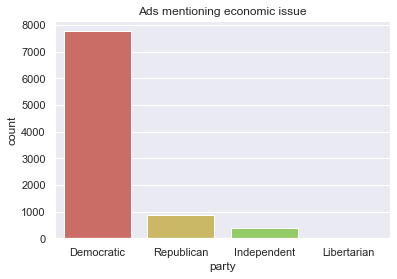

In [360]:
import seaborn as sns
import matplotlib.pyplot as plt

issue_name = 'economic_issues'
df_issue = test_merge[test_merge[issue_name]>0]
sns.set(style='darkgrid')
sns.set_palette("hls", 8)
sns.countplot(df_issue.party, order = df_issue.party.value_counts().index)
plt.title(f"Ads mentioning {issue_name.split('_')[0]} issuesb")
plt.show()

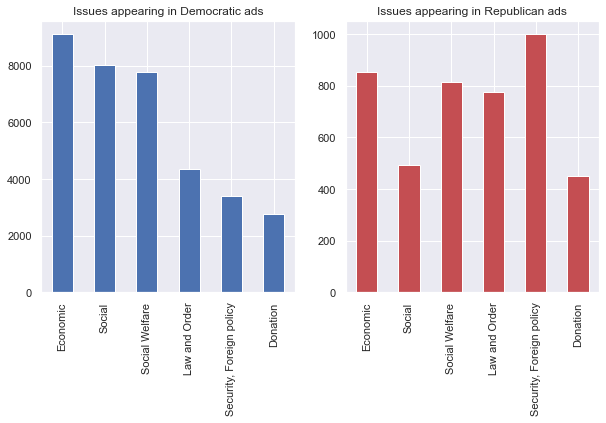

In [395]:
democrats = test_merge[test_merge.party=='Democratic']
republicans = test_merge[test_merge.party=='Republican']
broader_issues = [i for i in test_merge.columns if '_issues' in i]

fig, ax = plt.subplots(1,2, figsize=(10,5),sharex=True)
democrats[broader_issues].sum(axis=0).sort_values(ascending=False).plot(kind='bar', color='b', ax=ax[0])
republicans[broader_issues].sum(axis=0).plot(kind='bar', color='r', ax=ax[1])
ax[0].set_xticklabels(['Economic','Social','Social Welfare','Law and Order','Security, Foreign policy','Donation'])
ax[0].set_title('Issues appearing in Democratic ads')
ax[1].set_title('Issues appearing in Republican ads')
plt.show()

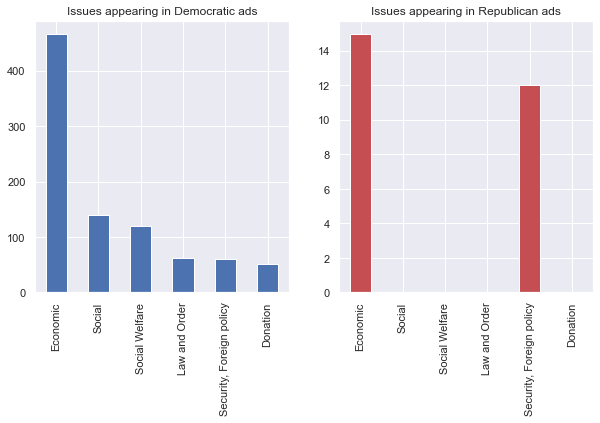

In [398]:
state = 'New York'
df_state = test_merge[test_merge.state==state]
democrats = df_state[df_state.party=='Democratic']
republicans = df_state[df_state.party=='Republican']
broader_issues = [i for i in df_state.columns if '_issues' in i]

fig, ax = plt.subplots(1,2, figsize=(10,5),sharex=True)
democrats[broader_issues].sum(axis=0).sort_values(ascending=False).plot(kind='bar', color='b', ax=ax[0])
republicans[broader_issues].sum(axis=0).plot(kind='bar', color='r', ax=ax[1])
ax[0].set_xticklabels(['Economic','Social','Social Welfare','Law and Order','Security, Foreign policy','Donation'])
ax[0].set_title('Issues appearing in Democratic ads')
ax[1].set_title('Issues appearing in Republican ads')
plt.show()